In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shwetabh123/mall-customers")

print("Path to dataset files:", path)

100%|██████████| 1.56k/1.56k [00:00<?, ?B/s]

Extracting files...
Path to dataset files: C:\Users\Omen\.cache\kagglehub\datasets\shwetabh123\mall-customers\versions\1


In [4]:
os.listdir(path)

['Mall_Customers.csv']

In [5]:
csv_path = os.path.join(path, "Mall_Customers.csv")
df = pd.read_csv(csv_path)

df.head()


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
#selecting features for clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]


In [7]:
#Feature Scaling
import numpy as np

X_np = X.values

mean = X_np.mean(axis=0)
std = X_np.std(axis=0)

X_scaled = (X_np - mean) / std


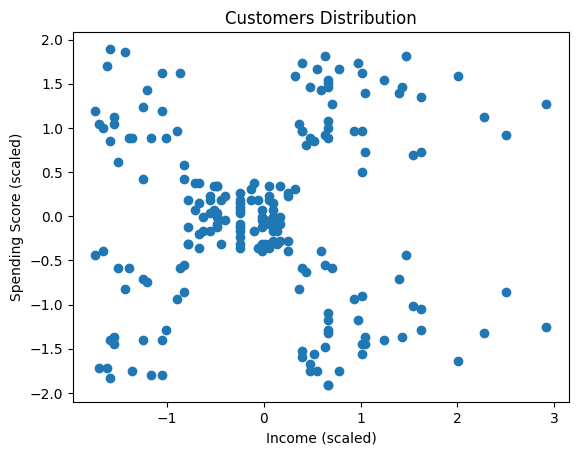

In [8]:
#visualization
import matplotlib.pyplot as plt

plt.scatter(X_scaled[:, 0], X_scaled[:, 1])
plt.xlabel("Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.title("Customers Distribution")
plt.show()


In [9]:
#K-Means Clustering

def kmeans(X, k, max_iters=100):
    # Randomly choose initial centroids
    np.random.seed(42)
    centroids = X[np.random.choice(len(X), k, replace=False)]

    for _ in range(max_iters):
        # Assign clusters
        distances = np.linalg.norm(X[:, None] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Update centroids
        new_centroids = np.array([
            X[labels == i].mean(axis=0) for i in range(k)
        ])

        # Convergence check
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids


In [10]:
#Find Optimal K
def inertia(X, labels, centroids):
    total = 0
    for i in range(len(centroids)):
        total += np.sum((X[labels == i] - centroids[i]) ** 2)
    return total


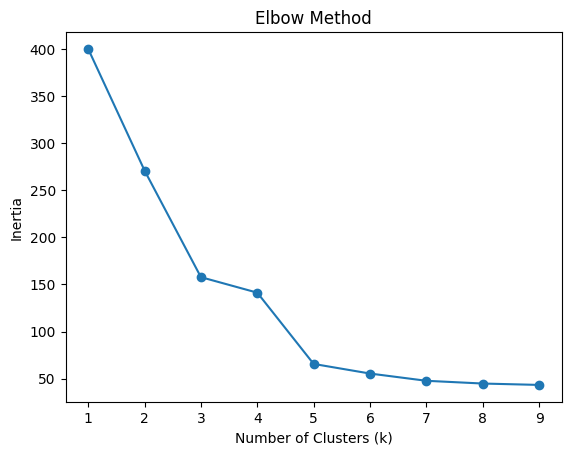

In [11]:
inertias = []
K = range(1, 10)

for k in K:
    labels, centroids = kmeans(X_scaled, k)
    inertias.append(inertia(X_scaled, labels, centroids))

plt.plot(K, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [12]:
#Final K-Means Clustering
labels, centroids = kmeans(X_scaled, k=5)


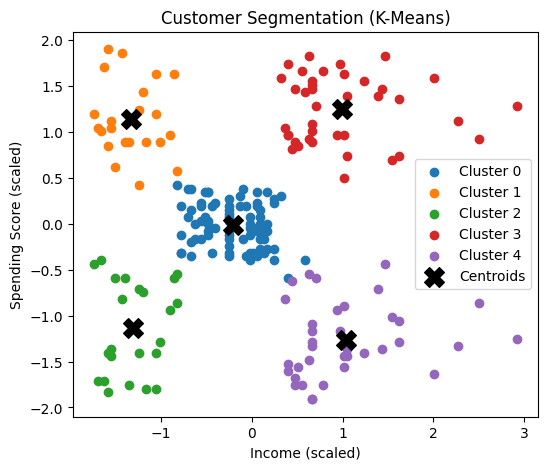

In [13]:
#visualize clusters
plt.figure(figsize=(6,5))

for i in range(5):
    plt.scatter(
        X_scaled[labels == i, 0],
        X_scaled[labels == i, 1],
        label=f"Cluster {i}"
    )

plt.scatter(
    centroids[:, 0], centroids[:, 1],
    color='black', marker='X', s=200, label="Centroids"
)

plt.xlabel("Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.legend()
plt.title("Customer Segmentation (K-Means)")
plt.show()


In [14]:
#DBSCAN
def dbscan(X, eps=0.5, min_pts=5):
    labels = np.full(len(X), -1)
    cluster_id = 0

    for i in range(len(X)):
        if labels[i] != -1:
            continue

        distances = np.linalg.norm(X - X[i], axis=1)
        neighbors = np.where(distances < eps)[0]

        if len(neighbors) < min_pts:
            labels[i] = -1
            continue

        labels[neighbors] = cluster_id
        cluster_id += 1

    return labels


In [15]:
db_labels = dbscan(X_scaled, eps=0.6, min_pts=5)


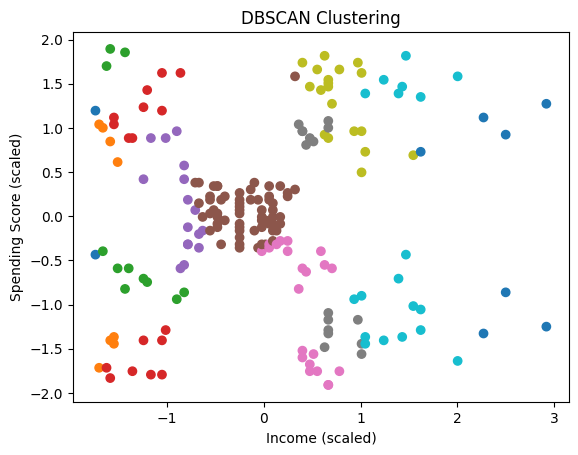

In [16]:
#visualization
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=db_labels, cmap='tab10')
plt.xlabel("Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.title("DBSCAN Clustering")
plt.show()


In [17]:
#Average Spending Per Cluster
df['Cluster'] = labels

cluster_summary = df.groupby('Cluster')['Spending Score (1-100)'].mean()
print(cluster_summary)



Cluster
0    49.712500
1    79.363636
2    20.913043
3    82.128205
4    17.583333
Name: Spending Score (1-100), dtype: float64


K-Means clustering was applied to segment customers based on income and spending behavior.
Feature scaling was performed to ensure equal contribution.
The elbow method identified the optimal number of clusters.
DBSCAN was also tested to identify density-based groupings and potential outliers